## Problem Statement
Predicting Turbine Energy Yield (TEY) using ambient variables as features.

## dataset

- The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
- The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.


## Attribute Information:

- The explanations of sensor measurements and their brief statistics are given below.

    - Variable (Abbr.) Unit Min Max Mean
    - Ambient temperature (AT) C â€“6.23 37.10 17.71
    - Ambient pressure (AP) mbar 985.85 1036.56 1013.07
    - Ambient humidity (AH) (%) 24.08 100.20 77.87
    - Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
    - Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
    - Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
    - Turbine after temperature (TAT) C 511.04 550.61 546.16
    - Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
    - Turbine energy yield (TEY) MWH 100.02 179.50 133.51
    - Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
    - Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29


## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import warnings
warnings.filterwarnings('ignore')

## 2. Import Dataset

In [2]:
df = pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


## 3. Data Exploration

In [3]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [4]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [5]:
df.shape

(15039, 11)

In [6]:
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [7]:
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [9]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [10]:
df.corr()["TEY"]

AT     -0.207495
AP      0.146939
AH     -0.110272
AFDP    0.717995
GTEP    0.977042
TIT     0.891587
TAT    -0.720356
TEY     1.000000
CDP     0.988473
CO     -0.541751
NOX    -0.102631
Name: TEY, dtype: float64

In [11]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

## 4. Data Visualization

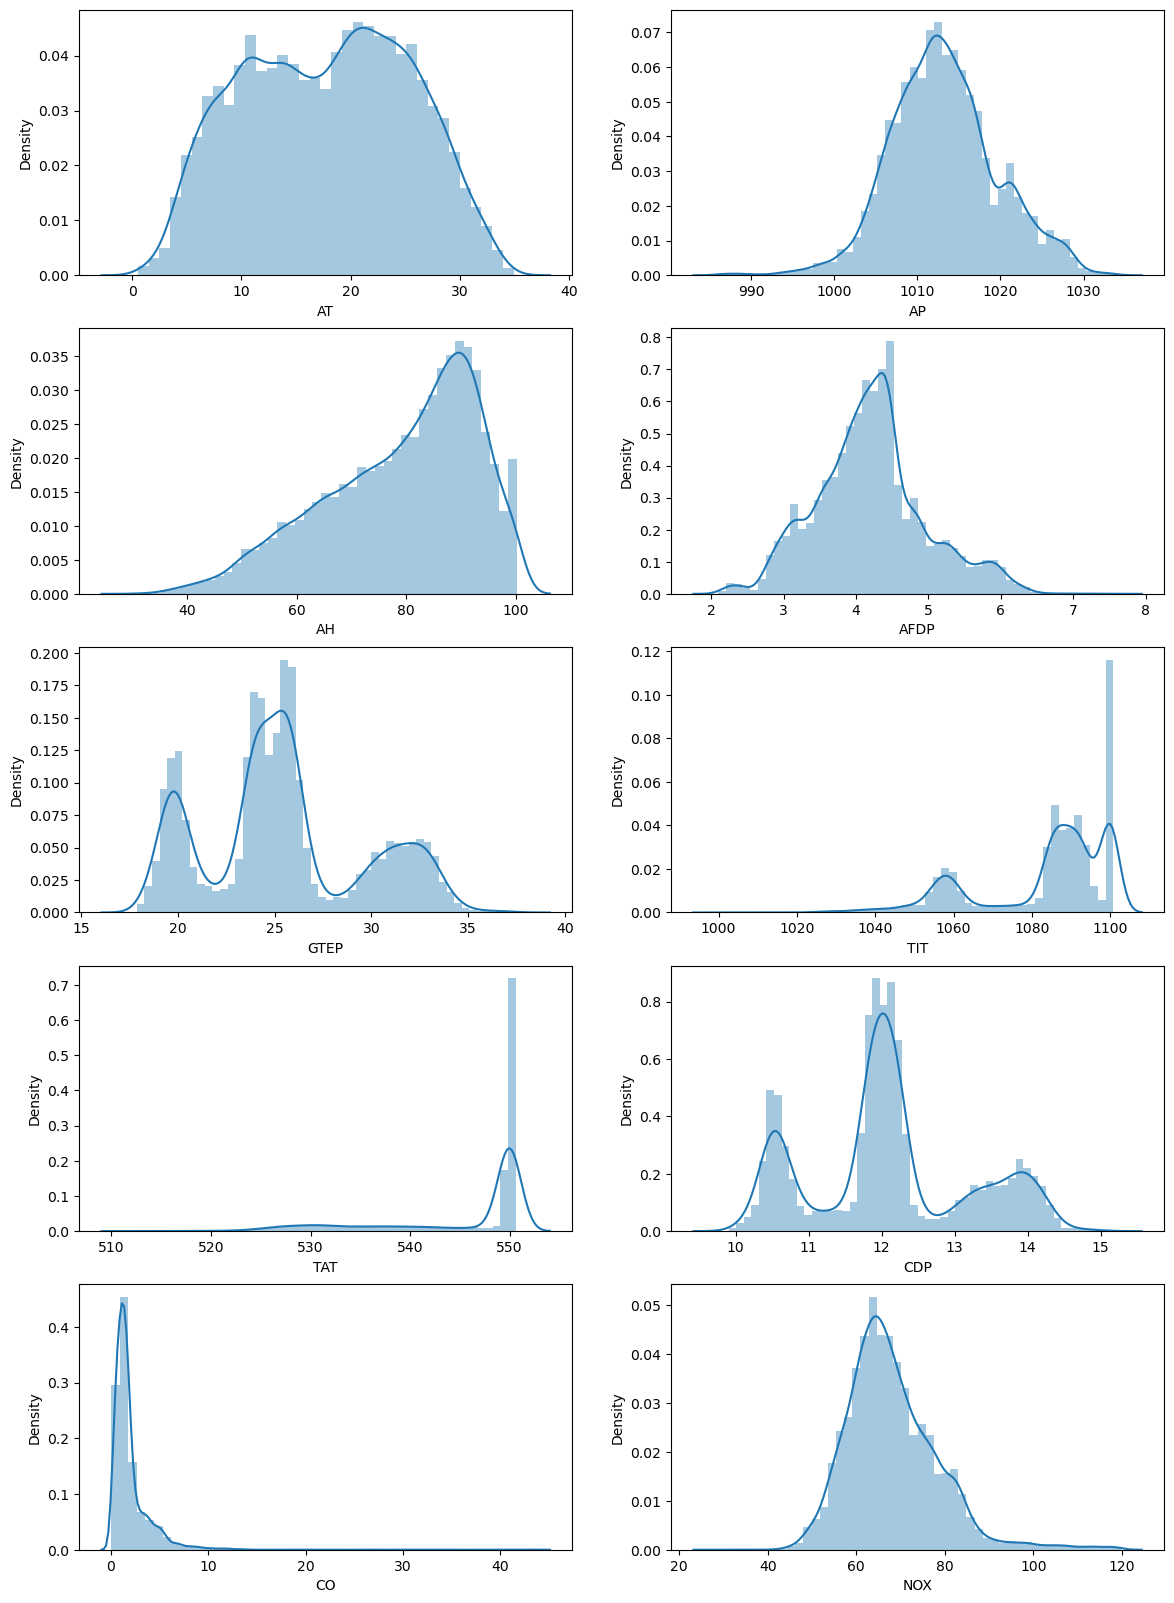

In [12]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.distplot(df.AT, ax = ax[0,0])
sns.distplot(df.AP, ax = ax[0,1])
sns.distplot(df.AH, ax = ax[1,0])
sns.distplot(df.AFDP, ax = ax[1,1])
sns.distplot(df.GTEP, ax = ax[2,0])
sns.distplot(df.TIT, ax = ax[2,1])
sns.distplot(df.TAT, ax = ax[3,0])
sns.distplot(df.CDP, ax = ax[3,1])
sns.distplot(df.CO, ax = ax[4,0])
sns.distplot(df.NOX, ax = ax[4,1])

plt.show()

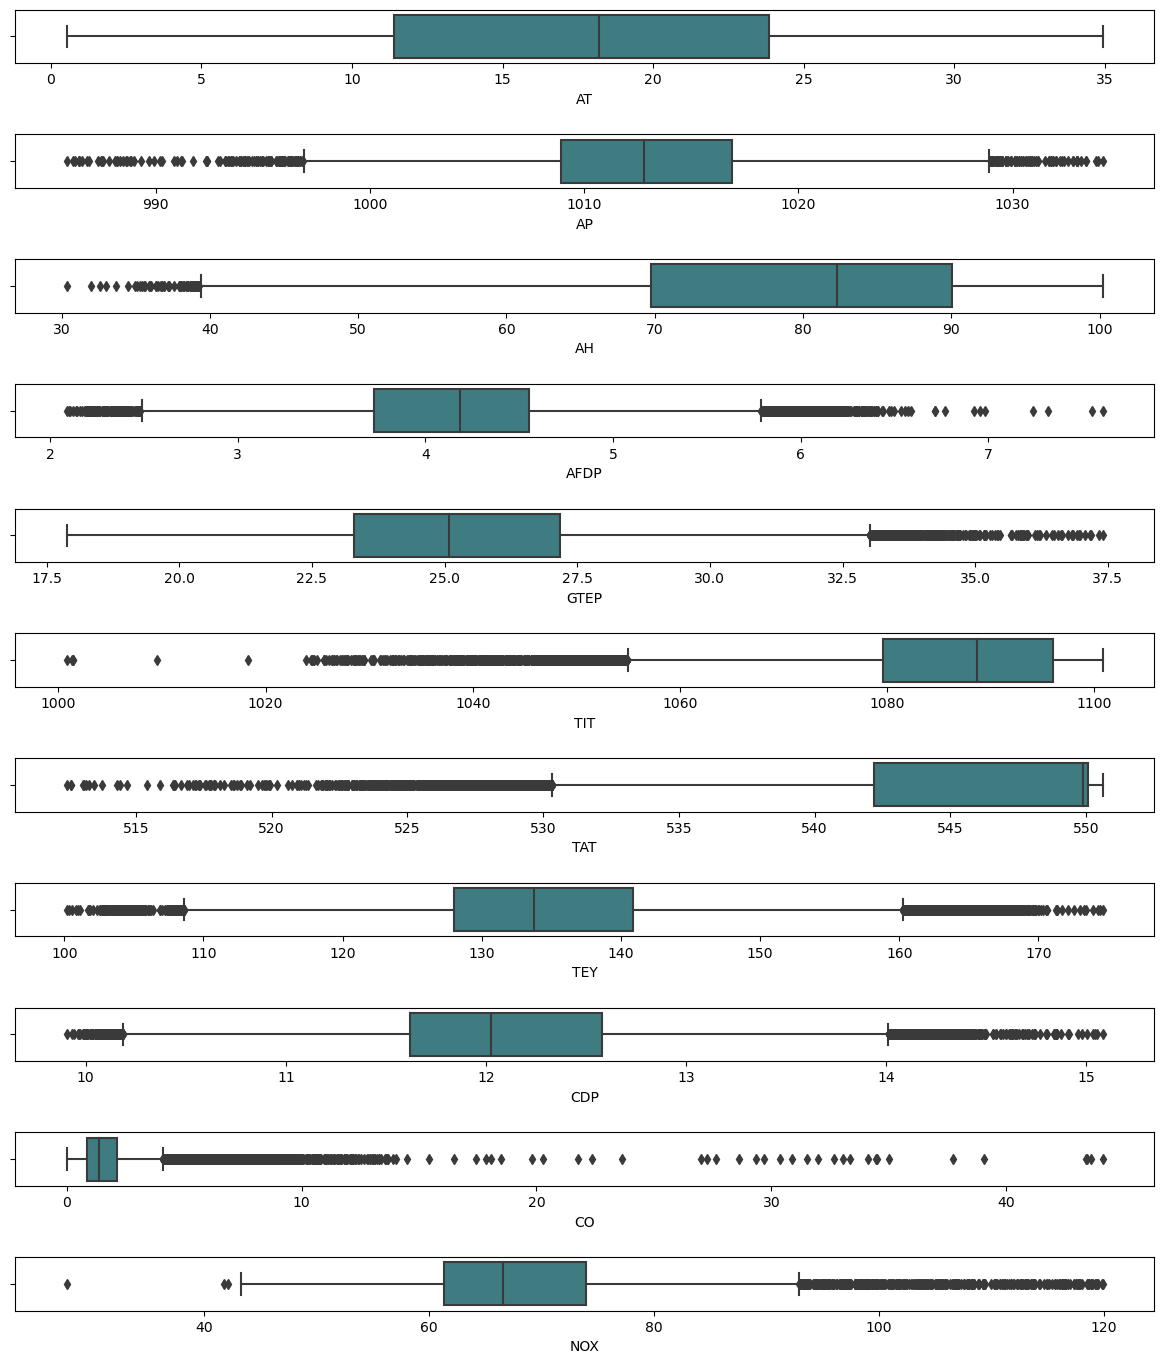

In [13]:
outlier = df.copy() 
fig, axes=plt.subplots(11,1,figsize=(12,14),sharex=False,sharey=False)
sns.boxplot(x='AT',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data= outlier,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data= outlier,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data= outlier,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data= outlier,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data= outlier,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data= outlier,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data= outlier,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data= outlier,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data= outlier,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

<AxesSubplot:xlabel='TEY', ylabel='Count'>

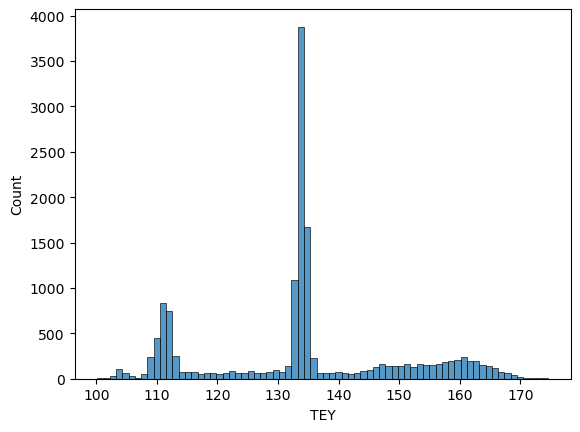

In [14]:
sns.histplot(data=df["TEY"])

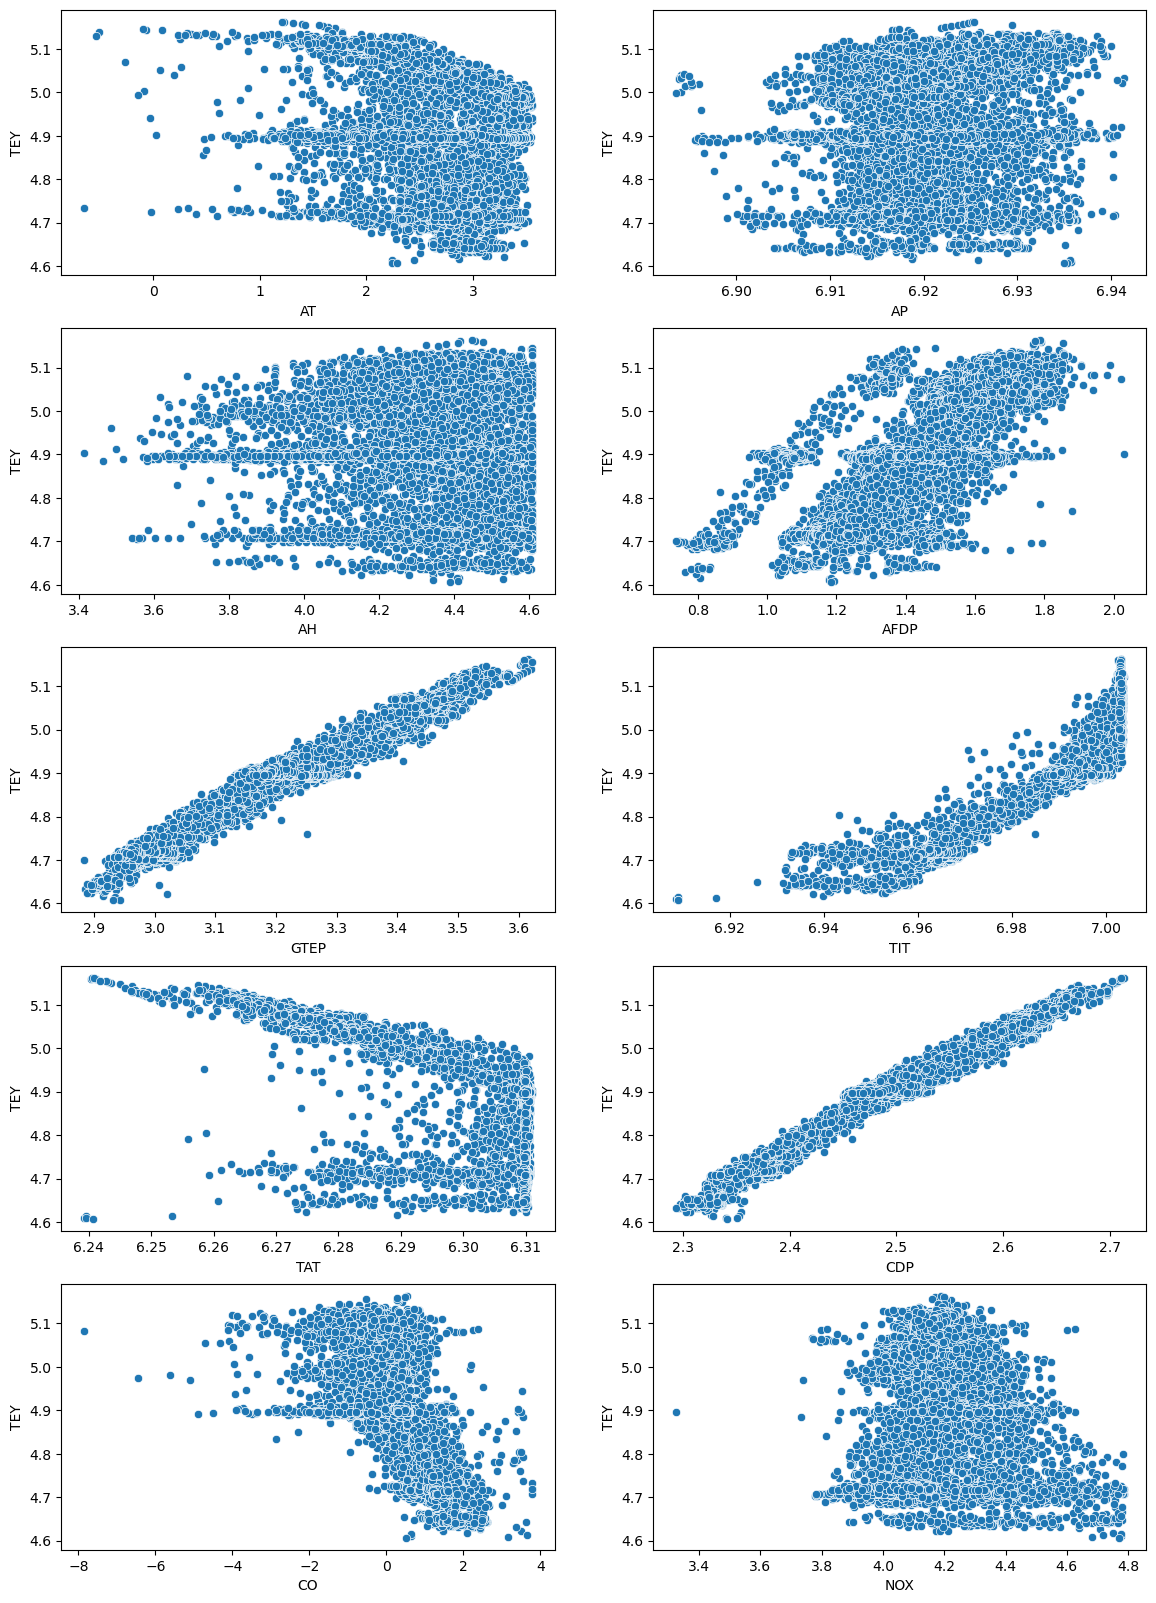

In [15]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.scatterplot(np.log(df['AT']), np.log(df['TEY']),ax= ax[0,0])
sns.scatterplot(np.log(df['AP']), np.log(df['TEY']), ax= ax[0,1])
sns.scatterplot(np.log(df['AH']), np.log(df['TEY']), ax= ax[1,0])
sns.scatterplot(np.log(df['AFDP']), np.log(df['TEY']),ax= ax[1,1])
sns.scatterplot(np.log(df['GTEP']), np.log(df['TEY']), ax= ax[2,0])
sns.scatterplot(np.log(df['TIT']), np.log(df['TEY']), ax= ax[2,1])
sns.scatterplot(np.log(df['TAT']), np.log(df['TEY']), ax= ax[3,0])
sns.scatterplot(np.log(df['CDP']), np.log(df['TEY']), ax= ax[3,1])
sns.scatterplot(np.log(df['CO']), np.log(df['TEY']), ax= ax[4,0])
sns.scatterplot(np.log(df['NOX']), np.log(df['TEY']), ax= ax[4,1])

plt.show()

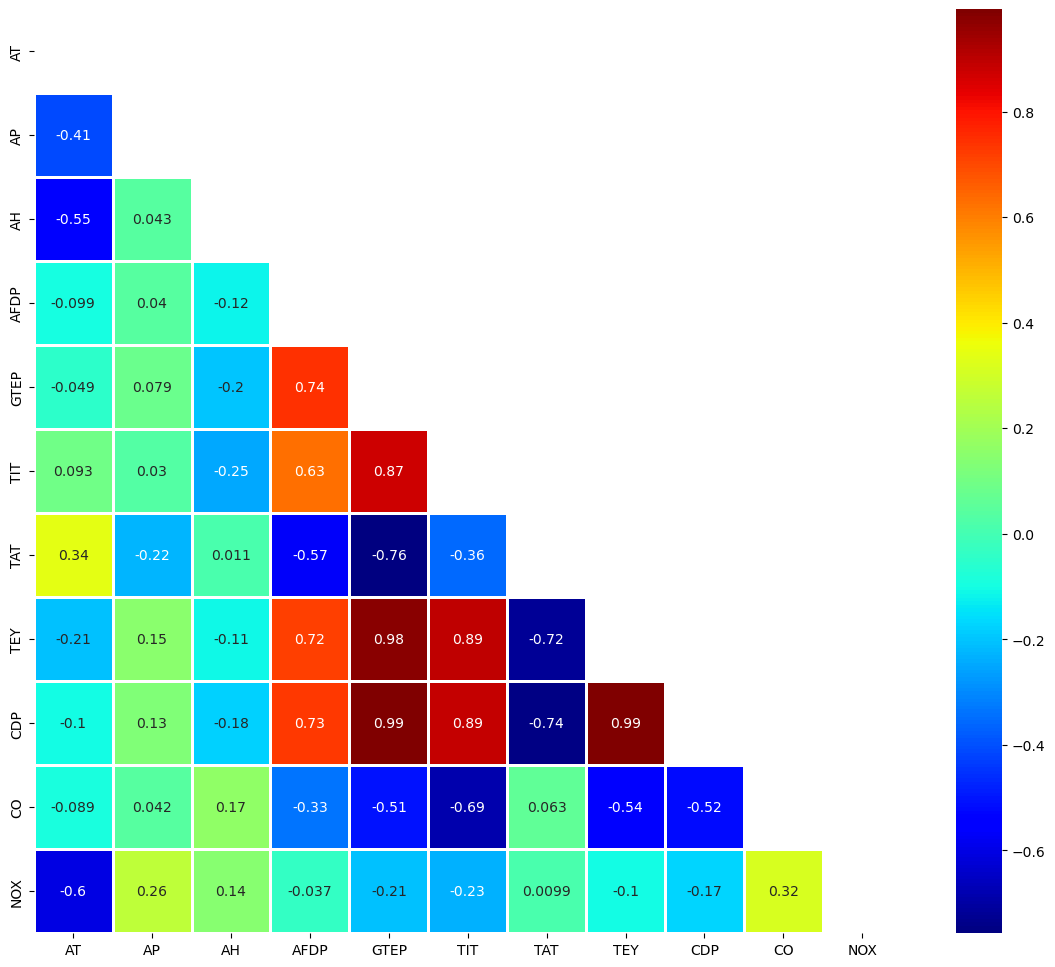

In [16]:
plt.figure(figsize=(14,12))
mask = np.zeros_like(df.corr(), dtype= np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data= df.corr(), cmap= "jet", annot= True, linewidths= 1, linecolor= 'white', mask=mask);

In [17]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

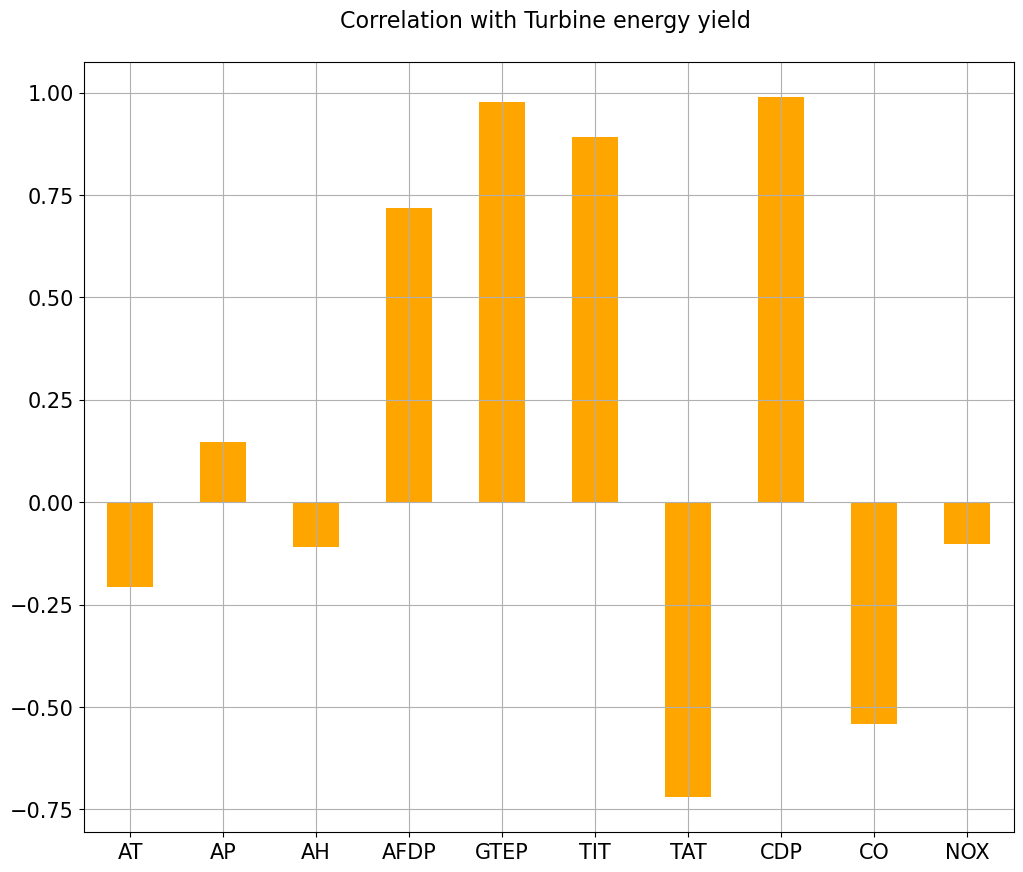

In [18]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize=(12,10), fontsize = 15, color = 'orange', rot = 0, grid = True)
plt.title('Correlation with Turbine energy yield \n', fontsize = "16", fontfamily = "sans-serif")
plt.show()

## 5. Data Pre-Processing

In [19]:
from numpy import set_printoptions
from sklearn.feature_selection import mutual_info_regression

### Feature Extraction

In [20]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

### Summarize Scores

In [21]:
scores = fit.scores_
features = fit.transform(x)

In [22]:
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.713465,CDP
4,1.601427,GTEP
5,1.328297,TIT
6,0.894814,TAT
3,0.660662,AFDP
8,0.512804,CO
0,0.412509,AT
9,0.301059,NOX
1,0.137501,AP
2,0.097819,AH


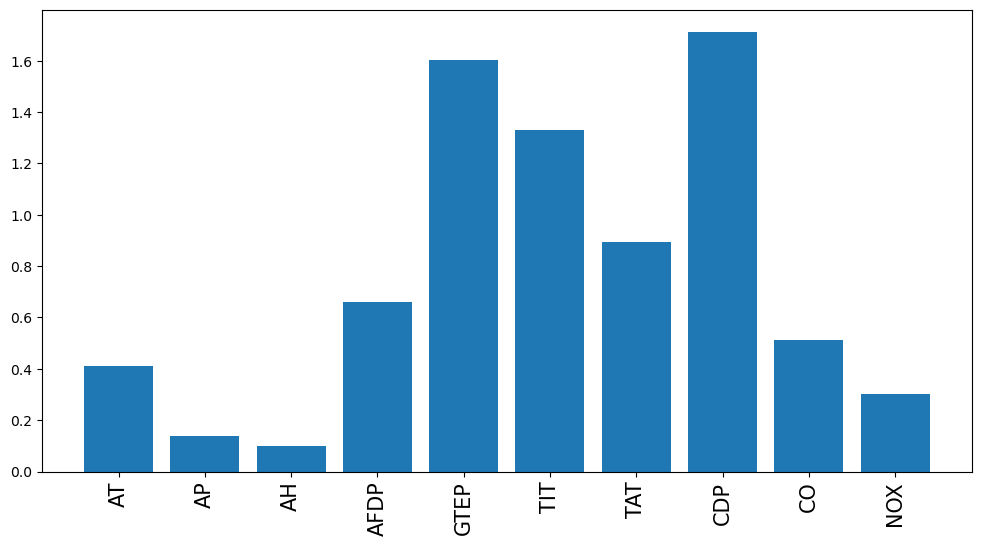

In [23]:
fig, axes = plt.subplots(figsize=(12,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

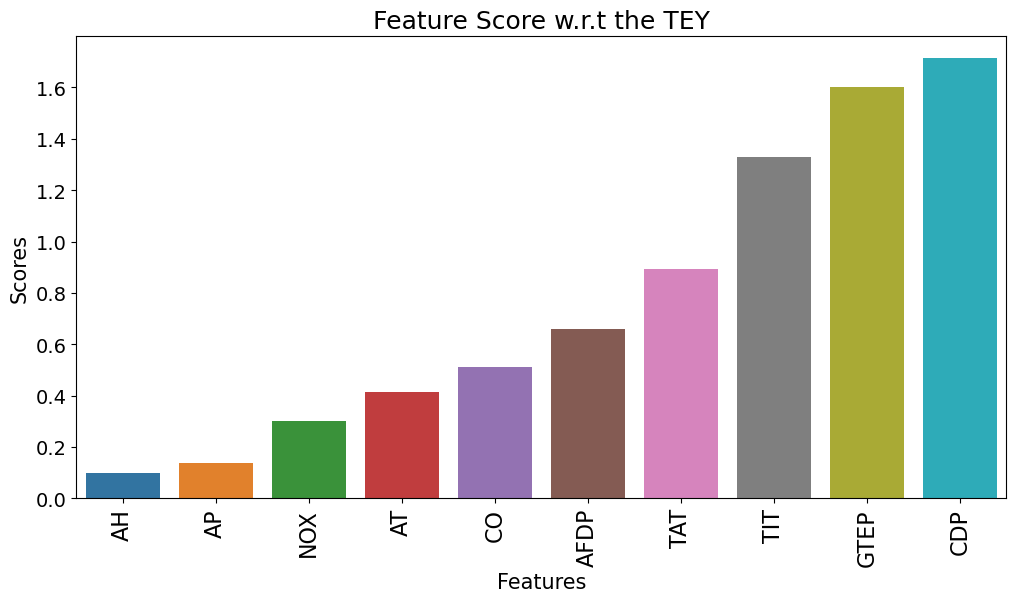

In [24]:
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y="Score", data=score_df, order=score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the TEY", size=18)
plt.show()

In [25]:
score_df.sort_values('Score', ascending=False)

,Score,Feature
7,1.713465,CDP
4,1.601427,GTEP
5,1.328297,TIT
6,0.894814,TAT
3,0.660662,AFDP
8,0.512804,CO
0,0.412509,AT
9,0.301059,NOX
1,0.137501,AP
2,0.097819,AH


In [26]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


### Feature Engineering
### Applying Standard Scaler

In [27]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [28]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


In [30]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))

Mean
 CDP     0.0
GTEP    0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT     -0.0
TEY     0.0
dtype: float64


In [31]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std(),1))

Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64


### 5.3 Test Train Split With Imbalanced Dataset

In [32]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

## 6. Hyperparameter Tuning

In [34]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

In [35]:
print(np.version.version)

1.22.3


In [36]:
from keras_tuner.tuners import RandomSearch

In [37]:
tuner = RandomSearch(build_model, objective= 'val_mean_absolute_error', max_trials= 5,
                     executions_per_trial= 3, directory= 'project', project_name= 'Gas Turbine')
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Trial 5 Complete [00h 07m 40s]
val_mean_absolute_error: 0.02387862652540207

Best val_mean_absolute_error So Far: 0.02387862652540207
Total elapsed time: 00h 33m 01s
INFO:tensorflow:Oracle triggered exit


In [39]:
tuner.results_summary()

Results summary
Results in project\Gas Turbine
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 17
units_0: 96
units_1: 96
learning_rate: 0.0001
units_2: 64
units_3: 32
units_4: 32
units_5: 64
units_6: 64
units_7: 32
units_8: 32
units_9: 96
units_10: 64
units_11: 64
units_12: 96
units_13: 96
units_14: 96
units_15: 64
units_16: 96
Score: 0.02387862652540207

Trial 1 summary
Hyperparameters:
num_layers: 17
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 64
units_3: 96
units_4: 96
units_5: 96
units_6: 64
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
Score: 0.024124013880888622

Trial 3 summary
Hyperparameters:
num_layers: 9
units_0: 32
units_1: 64
learning_rate: 0.0001
units_2: 96
units_3: 64
units_4: 32
units_5: 64
units_6: 64
units_7: 96
units_8: 32
units_9: 64
units_10: 64
units_11: 96
units_12: 64
units_13: 64
units_14: 

### Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [40]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model1

In [41]:
model1     = KerasRegressor(build_fn=create_model,verbose=0)
batch_size = [20,40,50]
epochs     = [50,100,200]
param_grid = dict(batch_size= batch_size, epochs= epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [42]:
grid_result1 = grid.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=20, epochs=50....................................
[CV 1/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.031 total time=  20.1s
[CV 2/5; 1/9] START batch_size=20, epochs=50....................................
[CV 2/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.029 total time=  19.8s
[CV 3/5; 1/9] START batch_size=20, epochs=50....................................
[CV 3/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.051 total time=  20.3s
[CV 4/5; 1/9] START batch_size=20, epochs=50....................................
[CV 4/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.027 total time=  19.3s
[CV 5/5; 1/9] START batch_size=20, epochs=50....................................
[CV 5/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.041 total time=  20.1s
[CV 1/5; 2/9] START batch_size=20, epochs=100...................................
[CV 1/5; 2/9] END ...batch_size=20, epochs=100;, 

In [43]:
print('Best {}, using {}'.format(grid_result1.best_score_, grid_result1.best_params_))
means  = grid_result1.cv_results_["mean_test_score"]
stds   = grid_result1.cv_results_["std_test_score"]
params = grid_result1.cv_results_["params"]
for mean,stdev,param in zip(means, stds,params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.027361537888646127, using {'batch_size': 20, 'epochs': 200}
-0.03586280047893524, 0.008792664383879472 with {'batch_size': 20, 'epochs': 50}
-0.031089233234524727, 0.0032364199359754178 with {'batch_size': 20, 'epochs': 100}
-0.027361537888646127, 0.001089599512531538 with {'batch_size': 20, 'epochs': 200}
-0.03411577828228474, 0.006179366788487355 with {'batch_size': 40, 'epochs': 50}
-0.030812224373221397, 0.0031327707809877176 with {'batch_size': 40, 'epochs': 100}
-0.028726783767342567, 0.00039966944138706195 with {'batch_size': 40, 'epochs': 200}
-0.03432190679013729, 0.005099495178428949 with {'batch_size': 50, 'epochs': 50}
-0.028373993188142776, 0.0016975137455249008 with {'batch_size': 50, 'epochs': 100}
-0.028466745838522912, 0.001385832116546067 with {'batch_size': 50, 'epochs': 200}


### 6.3 Hyperparameter Tuning: Optimal Droupout rate

In [44]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model2.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model2

In [45]:
model2       = KerasRegressor(build_fn= create_model, batch_size= 40, epochs= 200, verbose= 0)
dropout_rate = [0.0,0.1,0.2,0.3,0.4,0.5]
param_grid   = dict(dropout_rate= dropout_rate)
grid2        = GridSearchCV(estimator= model2, param_grid= param_grid, cv= KFold(), verbose= 10)

In [46]:
grid_result2 = grid2.fit(x_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.029 total time=  42.2s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  39.9s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.029 total time=  41.9s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.030 total time=  43.5s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.027 total time=  42.0s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [47]:
print('Best {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds  = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.027743859961628915, using {'dropout_rate': 0.2}
-0.029576654732227325, 0.0015727477423829734 with {'dropout_rate': 0.0}
-0.029360616207122804, 0.00196530375106116 with {'dropout_rate': 0.1}
-0.027743859961628915, 0.0012700408224624487 with {'dropout_rate': 0.2}
-0.030026597529649736, 0.005535894339027217 with {'dropout_rate': 0.3}
-0.031167737767100336, 0.002901269330900693 with {'dropout_rate': 0.4}
-0.03000672459602356, 0.0017388101731796298 with {'dropout_rate': 0.5}


### 6.4 Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer

In [48]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model3.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model3

In [49]:
model3 = KerasRegressor(build_fn=create_model, batch_size=40,epochs=200,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10)

In [50]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.613 total time= 1.0min
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.463 total time= 1.0min
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.581 total time=  58.6s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.204 total time= 1.0min
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.384 total time=  59.7s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [51]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds  = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.3598221123218536, using {'activation_function': 'tanh', 'init': 'normal'}
-0.44879030585289004, 0.14735835865454788 with {'activation_function': 'softmax', 'init': 'normal'}
-0.4376224011182785, 0.18895643418178773 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.3617262363433838, 0.1885778842798213 with {'activation_function': 'softmax', 'init': 'zero'}
-0.3598221123218536, 0.2108649836531184 with {'activation_function': 'tanh', 'init': 'normal'}
-0.4643522769212723, 0.21213814781489848 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.5543384104967117, 0.19582256201670634 with {'activation_function': 'tanh', 'init': 'zero'}
-0.3779449075460434, 0.19546718964953005 with {'activation_function': 'relu', 'init': 'normal'}
-0.5711481690406799, 0.15743645957924302 with {'activation_function': 'relu', 'init': 'uniform'}
-0.38822738230228426, 0.198671971896525 with {'activation_function': 'relu', 'init': 'zero'}


## 7. Model Building Neural Networks
### Standardizing only predictor variable - after train test split

In [52]:
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


### Assigning predictor variables to x and response variable to y

In [53]:
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test)   # scaling test data -- predictor

print("x_train_scaled :", x_train_scaled.shape)
print("x_test_scaled  :",x_test_scaled.shape)
print("y_train        :",y_train.shape)
print("y_test         :",y_test.shape)

x_train_scaled : (12031, 7)
x_test_scaled  : (3008, 7)
y_train        : (12031, 1)
y_test         : (3008, 1)


### Since we have continuous ouput, AF is not required in the o/p layer

In [54]:
model = Sequential()
model.add( Dense(units= 50, activation= 'relu', kernel_initializer= 'normal', input_dim= 7)) # input layer
model.add( Dense(units= 20, activation= 'tanh', kernel_initializer= 'normal')) # hidden layer
model.add( Dense(units= 1, kernel_initializer= 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss= "mse", metrics= ["mae", "mse"])
history = model.fit(x_train_scaled, y_train, batch_size= 50, validation_split= 0.3, epochs=10,  verbose=1)

Epoch 1/10
169/169 [==============================] - 2s 4ms/step - loss: 17622.0566 - mae: 131.7890 - mse: 17622.0586 - val_loss: 16782.6133 - val_mae: 128.5871 - val_mse: 16782.6133
Epoch 2/10
169/169 [==============================] - 0s 3ms/step - loss: 16288.2188 - mae: 126.6295 - mse: 16288.2207 - val_loss: 15733.5801 - val_mae: 124.4410 - val_mse: 15733.5801
Epoch 3/10
169/169 [==============================] - 0s 3ms/step - loss: 15315.3711 - mae: 122.7299 - mse: 15315.3711 - val_loss: 14816.4756 - val_mae: 120.6999 - val_mse: 14816.4756
Epoch 4/10
169/169 [==============================] - 0s 3ms/step - loss: 14432.1406 - mae: 119.0755 - mse: 14432.1406 - val_loss: 13965.0127 - val_mae: 117.1197 - val_mse: 13965.0127
Epoch 5/10
169/169 [==============================] - 0s 3ms/step - loss: 13604.1074 - mae: 115.5490 - mse: 13604.1074 - val_loss: 13161.3203 - val_mae: 113.6369 - val_mse: 13161.3203
Epoch 6/10
169/169 [==============================] - 0s 3ms/step - loss: 12819.

In [55]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    # Defining list of hyperparameters
    batch_size_list = [10 , 15 , 20 ]
    epoch_list      = [10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # Create ANN model
            model = Sequential()
            
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]], columns=['batchsize','epochs','Accuracy'] ))
            
            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)

94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    97.941632
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.60419
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.6553
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 15 - epochs: 10 Accuracy: TEY    89.79212
dtype: float64
94/94 [==============================] - 0s 2ms/step
batch_size: 15 - epochs: 50 Accuracy: TEY    99.575798
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 15 - epochs: 100 Accuracy: TEY    99.539475
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 20 - epochs: 10 Accuracy: TEY    81.107132
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 20 - epochs: 50 Accuracy: TEY    99.474126
dtype: float64
94/94 [===========

### Training Model - using best params

In [56]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
model.fit(x_train_scaled,y_train, batch_size= 20, epochs= 10, verbose= 0)

### Model Evaluation Train and Test Error

### Predicting values from Model using same dataset

In [57]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 2ms/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,127.170639
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,127.170639
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,127.170639
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,127.170639
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,127.170639
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,127.170639
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,127.170639
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,127.170639
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,127.170639
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,127.170639


In [58]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis= 1 , inplace= True)

### Calculating Absolute Percent Error and Error

In [59]:
# Computing the absolute percent error
APE = 100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %'] = APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  89.71565285618641


,Actual,Predicted,APE %
13312,134.46,127.170639,5.421211
12627,111.88,127.170639,13.666999
6393,133.72,127.170639,4.897817
4990,133.79,127.170639,4.947575
12462,110.77,127.170639,14.806030


In [60]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,127.170639,5.421211,0.054212
1,111.88,127.170639,13.666999,-0.136670
2,133.72,127.170639,4.897817,0.048978
3,133.79,127.170639,4.947575,0.049476
4,110.77,127.170639,14.806030,-0.148060
...,...,...,...,...
3003,119.25,127.170639,6.642045,-0.066420
3004,133.74,127.170639,4.912039,0.049120
3005,146.31,127.170639,13.081376,0.130814
3006,150.07,127.170639,15.259120,0.152591


### Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

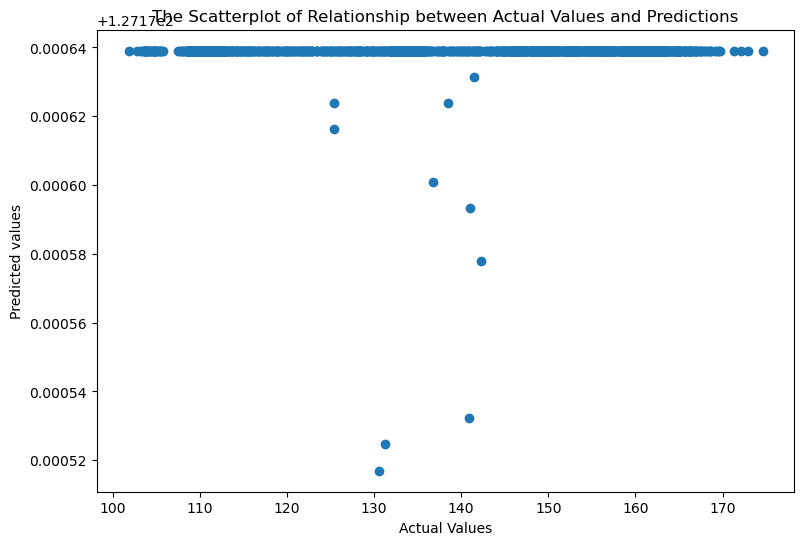

In [61]:
plt.figure(figsize=(9,6))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

#### We will evaluate our model performance by calculating the residual sum of squares and the explained variance score

In [62]:
from sklearn import metrics
print("MAE  :",metrics.mean_absolute_error(y_test,y_predict_test))
print("MSE  :",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE :",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE  : 14.064470346937789
MSE  : 296.4034172098036
RMSE : 17.216370616648668


In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train) : ',r2_score(y_train, y_predict_train))
print('R2_score (test)  : ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 1s 2ms/step
R2_score (train) :  -0.19983332371083895
R2_score (test)  :  -0.18376879962744286


### Evaluation of  the explained variance score (R^2)

In [64]:
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

This shows our model predict % -0.0 of the target correctly


### Residual Analysis

### Test for Normality of Residuals (Q-Q Plot)

<AxesSubplot:ylabel='Density'>

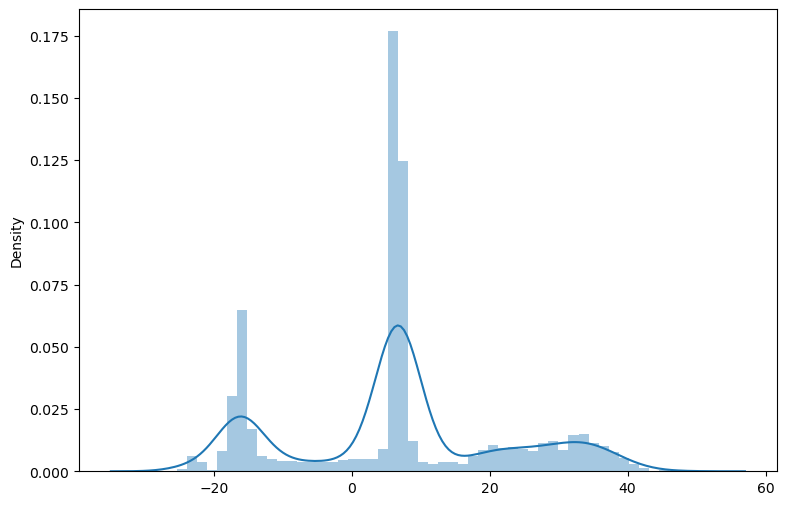

In [65]:
# Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(9,6))
sns.distplot(y_test-y_predict_test,bins=50) # this figure also proves that our model fits very good

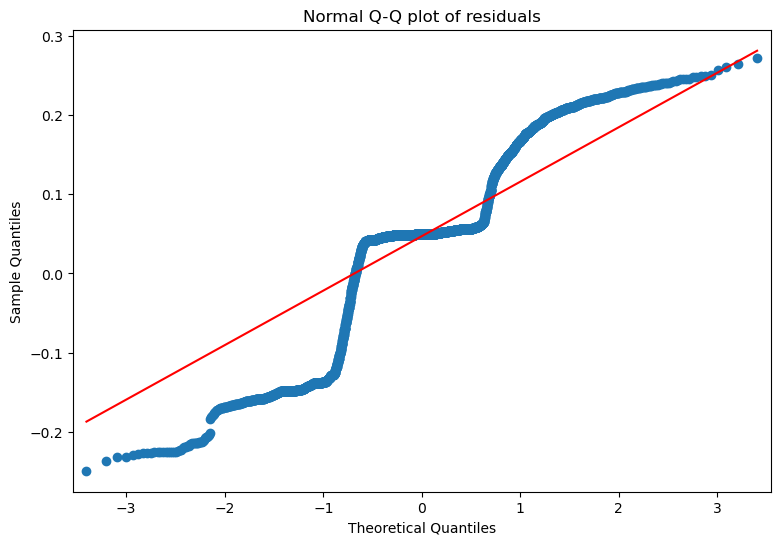

In [66]:
import statsmodels.api as smf
plt.rcParams["figure.figsize"] = (9,6)
smf.qqplot(predictions_df['Error'], line= 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()